<a href="https://colab.research.google.com/github/milkywayweaver/learn_pytorch/blob/main/course/PyT_C003_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
from torch import nn
print(torch.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2.6.0+cu124


# Plot Functions


This function is taken from the "helper functions.py" by Daniel Bourke.

✅ helper functions.py : https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py

✅ PyTorch Deep Learning : https://github.com/mrdbourke/pytorch-deep-learning

In [13]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    # from matplotlib.colors import ListedColormap
    # custom_cmap = ListedColormap(['#e6b7d2','#bae8a2'])
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap='PiYG', alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=4, cmap='PiYG')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# Main

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

💡 **Types of Classifications**
1. Multiclass classification : multiple classes, one class for each data
2. Multilabel classification : multiple labels for a single data


✅ Creating the data

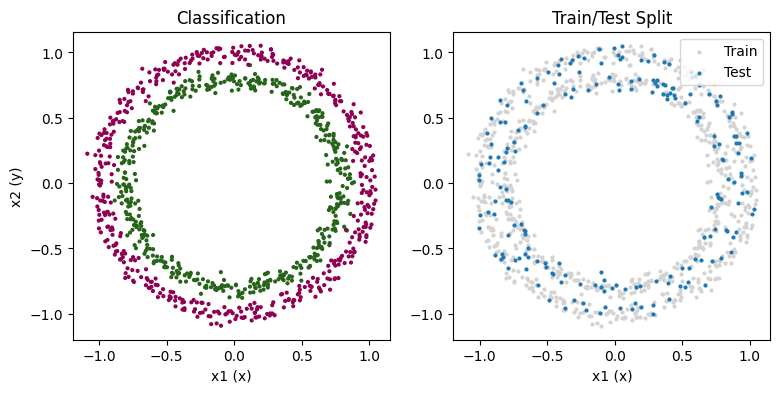

In [15]:
from sklearn import datasets

X,y = datasets.make_circles(n_samples=1000,noise=0.04,random_state=42)

X = torch.tensor(X,dtype=torch.float32,device=device)
y = torch.tensor(y,dtype=torch.float32,device=device).unsqueeze(1)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# PLOTTING =====================================================================

fig, ax = plt.subplots(1,2,figsize=(9,4))

ax[0].scatter(X[:,0].cpu(),X[:,1].cpu(),c=y.cpu(),cmap='PiYG',s=4)
ax[0].set_title('Classification')

ax[1].scatter(X_train[:,0].cpu(),X_train[:,1].cpu(),color='lightgrey',s=4,label='Train')
ax[1].scatter(X_test[:,0].cpu(),X_test[:,1].cpu(),color='C0',s=4,label='Test')
ax[1].legend(loc='upper right')
ax[1].set_title('Train/Test Split')

ax[0].set_xlabel('x1 (x)')
ax[0].set_ylabel('x2 (y)')
ax[1].set_xlabel('x1 (x)')

plt.show()

✅ Build the model

In [16]:
class BinaryClassificationModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_layer = nn.Linear(in_features=2,out_features=16,device=device)
    self.layer_1 = nn.Linear(in_features=16,out_features=16,device=device)
    self.layer_2 = nn.Linear(in_features=16,out_features=1,device=device)
    self.relu = nn.ReLU()

  def forward(self,x: torch.Tensor):
    return self.layer_2(self.relu(self.layer_1(self.relu(self.input_layer(x))))) # x -> input_layer -> layer_1

In [17]:
  model_2 = BinaryClassificationModel()
  model_2.state_dict()

OrderedDict([('input_layer.weight',
              tensor([[ 0.4424, -0.0320],
                      [-0.6823, -0.6329],
                      [-0.6586, -0.5203],
                      [-0.0944,  0.5381],
                      [ 0.6721,  0.4649],
                      [ 0.0889,  0.6328],
                      [-0.1892, -0.1784],
                      [ 0.2380,  0.2523],
                      [ 0.6903, -0.6968],
                      [-0.0580,  0.3673],
                      [-0.3687, -0.0293],
                      [ 0.6147, -0.3986],
                      [-0.4141, -0.3740],
                      [ 0.4640, -0.4966],
                      [-0.0183,  0.3307],
                      [-0.6883, -0.3517]])),
             ('input_layer.bias',
              tensor([ 0.4253,  0.2361, -0.3094,  0.6079,  0.3019,  0.3254,  0.5476, -0.1067,
                      -0.4499,  0.2304,  0.0062, -0.2764, -0.3342, -0.3813, -0.2833,  0.6033])),
             ('layer_1.weight',
              tensor([[ 0.0991, 

✅ Build a model using nn.Sequential()

In [18]:
 def BinaryClassificationModel2():
  model = nn.Sequential(
            nn.Linear(in_features=2,out_features=32,device=device),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=32,device=device),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=1,device=device)
          ).to(device)
  return model

✅ Train the model

In [19]:
def accuracy(y_pred,y_true):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = correct/len(y_pred)*100
  return acc

def train(model,epochs,lr):
  # Setup loss function and optimizer
  loss_fn = nn.BCEWithLogitsLoss()
  # nn.BCELoss requires input to have gone trough a sigmoid layer
  # nn.BCEWithLogitsLoss already has the sigmoid built-in
  optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)

  # Train the model
  for epoch in range(epochs):
    # Train
    model.train()
    y_logit = model(X_train)
    y_pred = torch.round(torch.sigmoid(y_logit))
    loss = loss_fn(y_logit,y_train) # This specific loss function requires logits as input, not probability
    acc = accuracy(y_pred,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate
    model.eval()
    with torch.inference_mode():
      test_logit = model(X_test)
      test_pred = torch.round(torch.sigmoid(test_logit))

      test_loss = loss_fn(test_logit,y_test)
      test_acc = accuracy(test_pred,y_test)

    if epoch % 50 == 0:
      print(f'Epoch: {epoch}\t| Loss: {loss:.3f}, Acc: {acc:.2f}\t| Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}')

In [20]:
model_0 = BinaryClassificationModel2()
train(model_0,501,0.001)
next(model_0.parameters()).device

Epoch: 0	| Loss: 0.697, Acc: 50.00	| Test Loss: 0.695, Test Acc: 50.00
Epoch: 50	| Loss: 0.672, Acc: 53.37	| Test Loss: 0.677, Test Acc: 53.00
Epoch: 100	| Loss: 0.611, Acc: 74.88	| Test Loss: 0.624, Test Acc: 69.00
Epoch: 150	| Loss: 0.480, Acc: 94.25	| Test Loss: 0.504, Test Acc: 93.50
Epoch: 200	| Loss: 0.303, Acc: 99.62	| Test Loss: 0.342, Test Acc: 96.50
Epoch: 250	| Loss: 0.176, Acc: 99.88	| Test Loss: 0.223, Test Acc: 97.50
Epoch: 300	| Loss: 0.110, Acc: 99.88	| Test Loss: 0.159, Test Acc: 98.50
Epoch: 350	| Loss: 0.075, Acc: 99.88	| Test Loss: 0.123, Test Acc: 98.50
Epoch: 400	| Loss: 0.056, Acc: 99.88	| Test Loss: 0.102, Test Acc: 98.50
Epoch: 450	| Loss: 0.043, Acc: 99.88	| Test Loss: 0.088, Test Acc: 98.50
Epoch: 500	| Loss: 0.035, Acc: 99.88	| Test Loss: 0.079, Test Acc: 98.50


device(type='cpu')

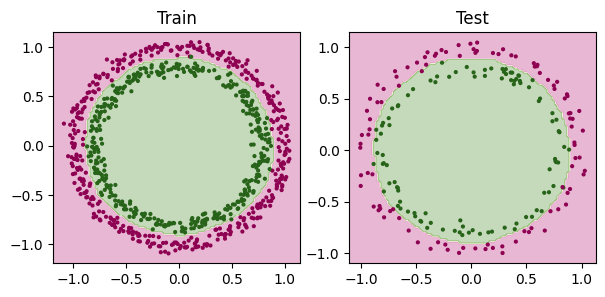

In [21]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0,X_test,y_test)

# Unused Codes

In [22]:
# with torch.inference_mode():
#   y_pred = model_0(X_test)
# # plt.scatter(X_test[:,0].cpu(),X_test[:,1].cpu(),c=y_pred.cpu())

# import requests
# from pathlib import Path
# if Path('helper_functions.py').is_file():
#   print('helper_functions is already downloaded.')
# else:
#   print('Downloading helper_functions.py...')
#   request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
#   with open('helper_functions.py','wb') as f:
#     f.write(request.content)
#   print('helper_functions successfully downloaded!')

# from helper_functions import plot_predictions, plot_decision_boundary